# rs_embed Playground

This notebook demonstrates **direct usage of `get_embedding`** from `rs_embed`,
without any wrapper utilities.

The goal is to clearly expose the **core toolkit API**:
- spatial inputs (`PointBuffer`, `BBox`)
- temporal specs (`year`, `range`)
- output specs (`pooled`, `grid`)
- returned `data` and `meta`

This is intended as a **transparent, reference-style notebook** rather than a benchmarking framework.


In [1]:
from rs_embed import BBox, PointBuffer, TemporalSpec, OutputSpec, get_embedding
from plot_utils import *

import json

## 1. Define spatial and temporal inputs

In [2]:
# Spatial: point + buffer
spatial_point = PointBuffer(
    lon=121.5,
    lat=31.2,
    buffer_m=2048,
)

# Spatial: bounding box
spatial_bbox = BBox(
    minlon=121.45,
    minlat=31.15,
    maxlon=121.55,
    maxlat=31.25,
)

# Temporal: single year
temporal_year = TemporalSpec.year(2024)

# Temporal: date range
temporal_range = TemporalSpec.range(
    "2022-06-01",
    "2022-09-01",
)

spatial_point, spatial_bbox, temporal_year, temporal_range

(PointBuffer(lon=121.5, lat=31.2, buffer_m=2048, crs='EPSG:4326'),
 BBox(minlon=121.45, minlat=31.15, maxlon=121.55, maxlat=31.25, crs='EPSG:4326'),
 TemporalSpec(mode='year', year=2024, start=None, end=None),
 TemporalSpec(mode='range', year=<function TemporalSpec.year at 0x149b3e052ac0>, start='2022-06-01', end='2022-09-01'))

## 2. Precomputed embedding example (`gse_annual`)

- Spatial: `BBox`
- Temporal: `year`
- Output: `grid`


{'geodesic': False, 'crs': {'type': 'name', 'properties': {'name': 'EPSG:3857'}}, 'type': 'Polygon', 'coordinates': [[[13519752.156843076, 3652244.858906867], [13530884.105922401, 3652244.858906867], [13530884.105922401, 3665259.1407130747], [13519752.156843076, 3665259.1407130747], [13519752.156843076, 3652244.858906867]]]}
data.shape: (64, 262, 223)
source: GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL


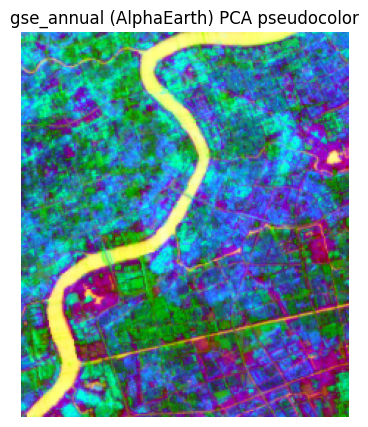

{'mean': array([ 0.07413001, -0.28650665,  0.15413521, -0.0253112 ,  0.00862007,
        -0.07432774, -0.11312833, -0.05009164, -0.1371307 ,  0.06712288,
         0.05033538,  0.06107465, -0.16814785, -0.13312885, -0.10743789,
        -0.10419264,  0.06163357,  0.15752198, -0.07909338,  0.06347679,
        -0.046253  ,  0.12228087, -0.07505996,  0.02022636, -0.07642836,
         0.22711334, -0.00739016, -0.03364813,  0.16963568,  0.05230838,
         0.05802605,  0.01400286, -0.07323356, -0.04847627,  0.11164466,
        -0.00030564, -0.2156751 , -0.04543701,  0.05896308,  0.01715563,
        -0.08380724, -0.03116898, -0.02428007,  0.04834802,  0.1065537 ,
         0.16576701, -0.06104701,  0.16087511,  0.14500451,  0.05259711,
        -0.09014613,  0.09355233, -0.19124341,  0.07489614,  0.19313456,
        -0.30133167,  0.01771099,  0.03049112,  0.03107022,  0.02131367,
        -0.03473804, -0.14158976, -0.07973306,  0.06004434], dtype=float32),
 'components': array([[-1.17960930e-01,

<Figure size 640x480 with 0 Axes>

In [3]:
emb = get_embedding(
    "gse_annual",
    spatial=spatial_bbox,
    temporal=temporal_year,
    output=OutputSpec.grid(scale_m=50),
)

print("data.shape:", emb.data.shape)
print("source:", emb.meta.get("source"))

plot_embedding_pseudocolor(
    emb,
    title="gse_annual (AlphaEarth) PCA pseudocolor",
)

## 3. On-the-fly model: `remoteclip_s2rgb`

### 3.1 Pooled output
- Spatial: `PointBuffer`
- Temporal: date range
- Output: `pooled(mean)`


In [4]:
emb_remoteclip_pooled = get_embedding(
    "remoteclip_s2rgb",
    spatial=spatial_point,
    temporal=temporal_range,
    output=OutputSpec.pooled(pooling="mean"),
)

print("data.shape:", emb_remoteclip_pooled.data.shape)
print("model:", emb_remoteclip_pooled.meta.get("model"))

print(json.dumps(emb_remoteclip_pooled.meta, indent=2)[:1500])

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights from local directory
data.shape: (768,)
model: remoteclip_s2rgb
{
  "model": "remoteclip_s2rgb",
  "type": "on_the_fly",
  "backend": "gee",
  "source": "COPERNICUS/S2_SR_HARMONIZED",
  "bands": [
    "B4",
    "B3",
    "B2"
  ],
  "scale_m": 10,
  "cloudy_pct": 30,
  "composite": "median",
  "start": "2022-06-01",
  "end": "2022-09-01",
  "ckpt": "MVRL/remote-clip-vit-base-patch32",
  "image_size": 224,
  "device": "auto",
  "pretrained_required": true,
  "auto_download": true,
  "hf_cache_dir": null,
  "ckpt_input": "MVRL/remote-clip-vit-base-patch32",
  "ckpt_local_dir": "/u/dingqi2/.cache/huggingface/hub/models--MVRL--remote-clip-vit-base-patch32/snapshots/db58b8873b15267f2b7ffe7e408a95ef5400469f",
  "weight_file": "/u/dingqi2/.cache/huggingface/hub/models--MVRL--remote-clip-vit-base-patch32/snapshots/db58b8873b15267f2b7ffe7e408a95ef5400469f/model.safetensors",
  "weight_file_size": 605145092,
  "weights_verified": true,
  "param_mean": -0.00023809839331079274,
  "

### 3.2 Grid output

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights from local directory
data.shape: (768, 7, 7)
grid_hw: (7, 7)


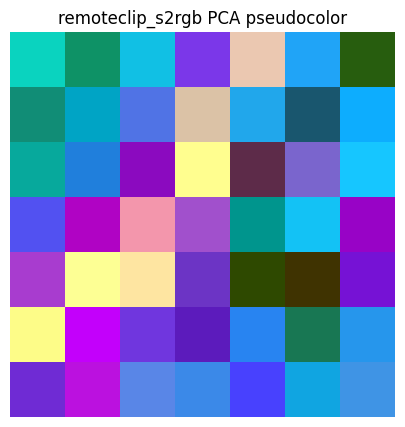

{'mean': array([-1.76906977e-02,  2.06798911e-01,  2.73429662e-01, -6.53784752e-01,
         6.10044062e-01, -8.09943557e-01,  6.67615160e-02, -3.52510810e-02,
        -1.79212436e-01, -1.80408806e-01, -3.89561802e-02,  5.67845702e-02,
         7.16561899e-02,  1.42418489e-01,  2.71564484e-01,  2.52629161e-01,
         5.96774578e-01, -2.27199662e-02, -1.01229660e-01,  1.30110338e-01,
        -1.21245250e-01, -2.17262626e-01, -2.87321925e-01,  2.59204894e-01,
        -3.17568094e-01,  7.02984706e-02, -1.82314496e-02,  2.72616625e-01,
         4.24753487e-01, -2.15760022e-01, -5.07746100e-01, -3.46954197e-01,
         1.86455011e-01,  9.60011408e-02,  1.97194085e-01,  1.94297552e-01,
        -2.10368648e-01,  5.18119812e-01,  4.66237329e-02, -2.38009810e-01,
         7.73941875e-01, -1.80109680e-01,  9.09734964e-02,  5.31410687e-02,
        -5.63504279e-01, -4.46667075e-01, -2.64440894e-01, -3.32388341e-01,
         2.62018740e-01,  2.16017276e-01,  1.84968486e-01,  3.50484729e-01,
    

<Figure size 640x480 with 0 Axes>

In [5]:
emb_remoteclip_grid = get_embedding(
    "remoteclip_s2rgb",
    spatial=spatial_point,
    temporal=temporal_range,
    output=OutputSpec.grid(),
)

print("data.shape:", emb_remoteclip_grid.data.shape)
print("grid_hw:", emb_remoteclip_grid.meta.get("grid_hw"))

plot_embedding_pseudocolor(
    emb_remoteclip_grid,
    title="remoteclip_s2rgb PCA pseudocolor",
)

## 4. `tessera` examples

### 4.1 Grid output (BBox, local backend)


data.shape: (128, 1097, 969)
meta keys: ['model', 'type', 'source', 'cache_dir', 'bbox_4326', 'preferred_year', 'chw_shape', 'tile_crs', 'mosaic_hw', 'crop_px_window', 'crop_hw', 'global_transform']


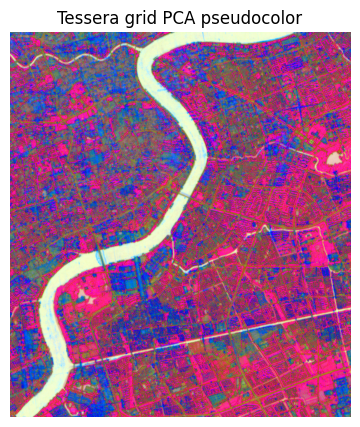

{'mean': array([ 3.1322482 , -2.883593  , -1.3132801 ,  4.0465426 , -0.7938378 ,
        -1.5668734 , -1.8587505 , -1.5470736 , -0.40700495,  1.7778176 ,
         0.02959265,  3.0493786 ,  1.1915911 , -3.0024762 , -1.8649864 ,
         0.8284257 , -0.4449093 ,  2.6083689 , -0.24676558,  1.1618873 ,
         2.73568   ,  2.0603268 ,  1.9394691 , -1.6016937 ,  4.9746614 ,
         0.97079104, -1.611119  ,  2.6287775 , -2.1276562 ,  3.378475  ,
        -2.1980977 ,  2.879958  , -2.2554111 ,  0.8785121 ,  1.7386643 ,
        -0.39240265,  3.5991158 ,  0.4560712 ,  0.30445766, -1.1600548 ,
         0.27436805, -2.1953154 ,  1.8300385 ,  2.6923273 ,  0.5492744 ,
         0.42342585,  0.1229492 , -1.7283446 ,  2.7872589 , -4.2722282 ,
        -2.4958408 , -0.9436266 , -2.385147  , -3.186416  ,  3.179219  ,
         3.01033   ,  0.916884  ,  0.25151712,  3.8009615 ,  1.755169  ,
         1.9650545 ,  0.07670196,  3.3304257 ,  3.5887744 ,  1.7283568 ,
        -0.09719083, -0.8570556 , -1.350091

<Figure size 640x480 with 0 Axes>

In [6]:
emb_tessera_grid = get_embedding(
    "tessera",
    spatial=spatial_bbox,
    temporal=temporal_year,
    output=OutputSpec.grid(),
    backend="local",
)

print("data.shape:", emb_tessera_grid.data.shape)
print("meta keys:", list(emb_tessera_grid.meta.keys()))

plot_embedding_pseudocolor(
    emb_tessera_grid,
    title="Tessera grid PCA pseudocolor",
)

### 4.2 Pooled output (PointBuffer)

In [7]:
emb_tessera_pooled = get_embedding(
    "tessera",
    spatial=spatial_point,
    temporal=temporal_year,
    output=OutputSpec.pooled(),
    backend="local",
)

print("data.shape:", emb_tessera_pooled.data.shape)
print("dim:", emb_tessera_pooled.meta.get("dim"))

data.shape: (128,)
dim: None


## 5. `copernicus_embed` (local backend)

100%|██████████| 768M/768M [00:01<00:00, 485MB/s] 


data.shape: (768, 4, 4)


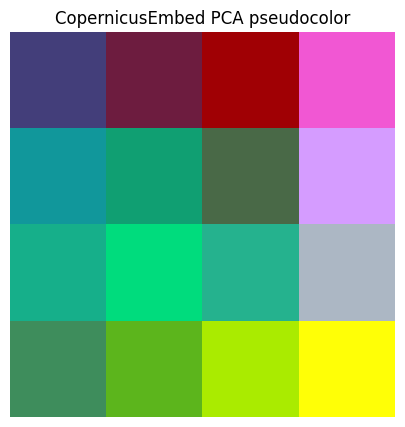

{'mean': array([-6.62231326e-01, -1.02608874e-01,  3.25848490e-01,  5.33732951e-01,
         5.20238400e-01, -7.37616301e-01,  9.10163403e-01,  3.36435020e-01,
        -4.58203018e-01, -4.28563833e-01,  2.32327342e-01, -1.28065872e+00,
         3.75901759e-01, -4.54569548e-01, -1.14987993e+00,  2.26949692e-01,
         1.10320997e+00,  3.38927060e-01, -2.39709556e-01,  5.63005172e-02,
         3.63123834e-01, -9.50055793e-02,  3.45632374e-01, -8.09691525e+00,
        -6.29177392e-02, -4.62233603e-01, -9.50398743e-02,  1.34505764e-01,
        -1.30617142e+01, -2.48391658e-01,  1.01915765e+00, -7.46000051e-01,
         5.34739017e-01,  5.96139848e-01,  2.76985645e-01,  4.15814549e-01,
        -6.06991768e-01,  6.69056058e-01, -1.00135303e+00, -3.23049098e-01,
         3.40744197e-01, -1.62872970e-02, -3.48878503e-01, -5.31999350e-01,
        -2.50054523e-04,  3.62773716e-01, -4.95694503e-02,  3.08843732e-01,
         4.58715409e-02, -1.34331718e-01, -1.79159820e-01,  9.89699543e-01,
    

<Figure size 640x480 with 0 Axes>

In [8]:
temporal_year = TemporalSpec.year(2021)
emb_cop_grid = get_embedding(
    "copernicus_embed",
    spatial=spatial_point,
    temporal=temporal_year,
    output=OutputSpec.grid(),
    backend="local",
)

print("data.shape:", emb_cop_grid.data.shape)

plot_embedding_pseudocolor(
    emb_cop_grid,
    title="CopernicusEmbed PCA pseudocolor",
)

## 6. Notes

- All examples above use **direct `get_embedding` calls**.
- This notebook intentionally avoids helper wrappers to keep the API explicit.
- For new models, copy an existing cell and modify:
  - `model name`
  - `spatial`
  - `temporal`
  - `OutputSpec`
